<a href="https://colab.research.google.com/github/o-semenkova/ml_home_tasks/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [24]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    roc_auc_score, f1_score
)
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:

drive.mount('/content/drive')
base_df = pd.read_csv("/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train.csv")
base_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [5]:
# Очистка: видаляємо зайві колонки
base_df.drop(['id','CustomerId', 'Surname'], axis=1, inplace=True)

In [6]:
# Розділяємо дані на тренувальні та валідаційні
train_df, val_df = train_test_split(base_df, test_size=0.2, random_state=42, stratify=base_df['Exited'])

In [7]:
# Створюємо нову фічу ProductGroup
for df in [train_df, val_df]:
    df['ProductGroup'] = df['NumOfProducts'].apply(lambda x: '3+' if x >= 3 else str(int(x)))

In [8]:
# Визначаємо ознаки
numeric_features = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance']
categorical_features = ['Geography', 'Gender', 'ProductGroup']
all_features = numeric_features + categorical_features

In [11]:
# Побудова препроцесора
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
])

In [12]:
# Пайплайн: препроцесор + логістична регресія
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [13]:
# Навчання моделі
pipeline.fit(train_df[all_features], train_df['Exited'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Age', 'NumOfProducts',
                                                   'IsActiveMember',
                                                   'Balance']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender',
                                                   'ProductGroup'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [16]:
def evaluate_model(pipeline, X, dataset_name='Dataset'):
    # 1. Прогноз ймовірностей
    y_proba = pipeline.predict_proba(X)[:, 1]

    # 2. Прогноз класів при порозі 0.5
    y_pred = (y_proba >= 0.5).astype(int)

    # 3. Confusion Matrix
    cm = confusion_matrix(X['Exited'], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.show()

    # 4. ROC Curve
    fpr, tpr, _ = roc_curve(X['Exited'], y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f'ROC Curve: {dataset_name}')
    plt.show()

    # 5. Метрики
    auc = roc_auc_score(X['Exited'], y_proba)
    f1 = f1_score(X['Exited'], y_pred)

    print(f"📊 {dataset_name} — AUROC: {auc:.3f}, F1 Score (threshold=0.5): {f1:.3f}")


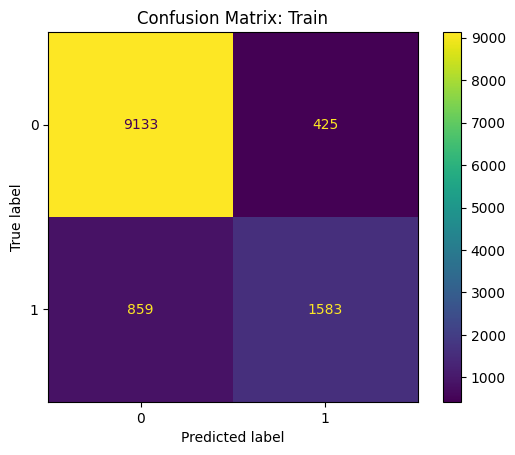

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


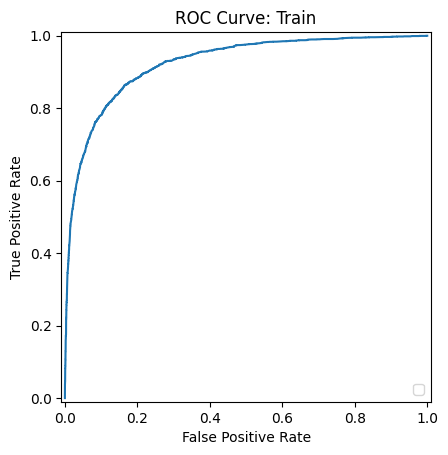

📊 Train — AUROC: 0.924, F1 Score (threshold=0.5): 0.711


In [19]:
evaluate_model(pipeline, train_df, 'Train')

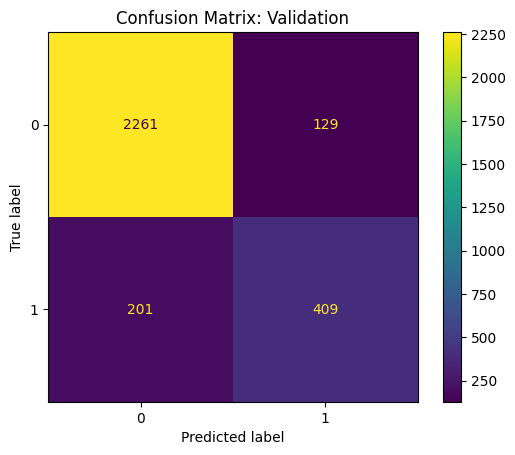

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


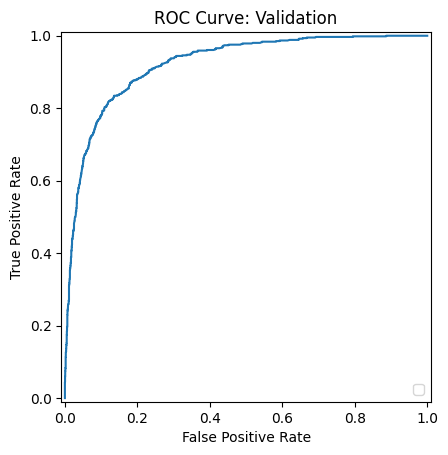

📊 Validation — AUROC: 0.922, F1 Score (threshold=0.5): 0.713


In [22]:
evaluate_model(pipeline, val_df, 'Validation')

In [23]:
bank_customer_churn_prediction_pipe = {
    'pipeline': pipeline,
    'preprocessor': preprocessor,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

joblib.dump(bank_customer_churn_prediction_pipe, '/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction_pipe.joblib')

['/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction_pipe.joblib']

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [25]:
# Препроцесор з PolynomialFeatures (до степеня 2)
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

preprocessor_poly = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Пайплайн з поліномами
pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Навчання
pipeline_poly.fit(train_df[all_features], train_df['Exited'])

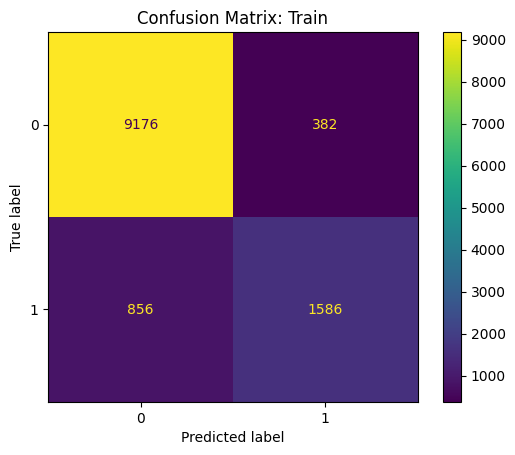

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


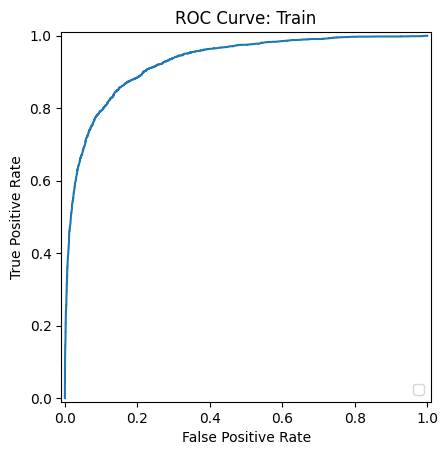

📊 Train — AUROC: 0.929, F1 Score (threshold=0.5): 0.719


In [26]:
evaluate_model(pipeline_poly, train_df, 'Train')

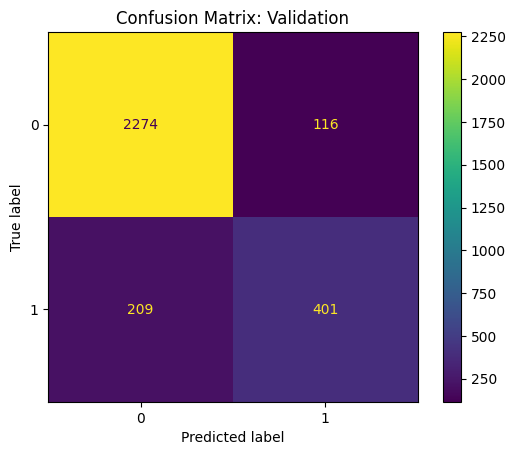

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


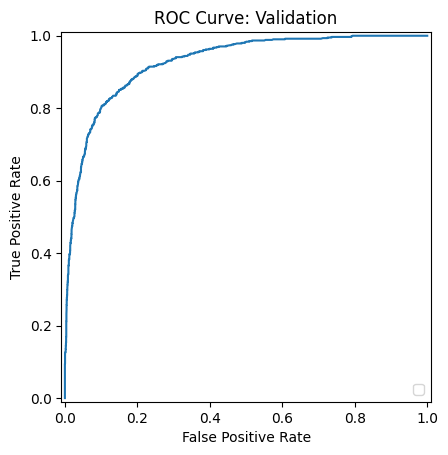

📊 Validation — AUROC: 0.927, F1 Score (threshold=0.5): 0.712


In [27]:
evaluate_model(pipeline_poly, val_df, 'Validation')

Ця модель генералізує трошки краще ніж попередня

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [29]:
# Препроцесор з PolynomialFeatures (до степеня 4)
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

preprocessor_poly_4 = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Пайплайн з поліномами
pipeline_poly_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_4),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Навчання
pipeline_poly_4.fit(train_df[all_features], train_df['Exited'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'NumOfProducts',
                                                   'IsActiveMember',
                                                   'Balance']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender',
                                                   'ProductGroup'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

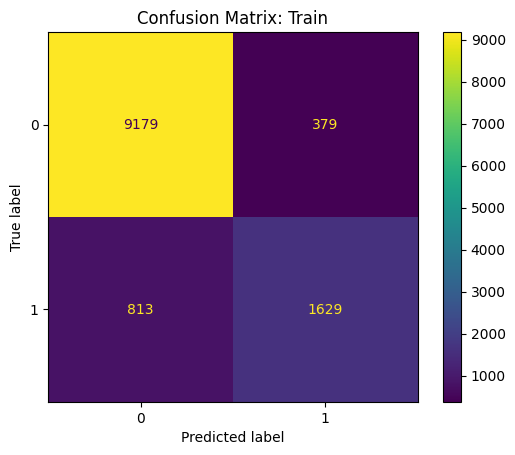

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


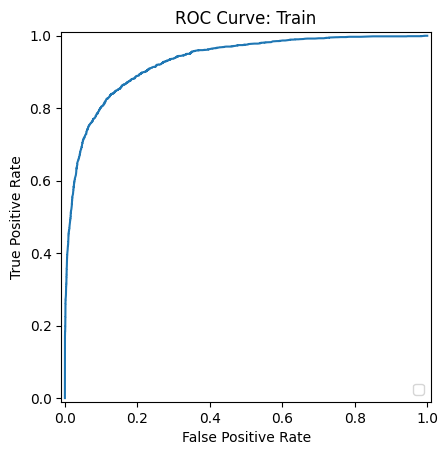

📊 Train — AUROC: 0.931, F1 Score (threshold=0.5): 0.732


In [31]:
evaluate_model(pipeline_poly_4, train_df, 'Train')

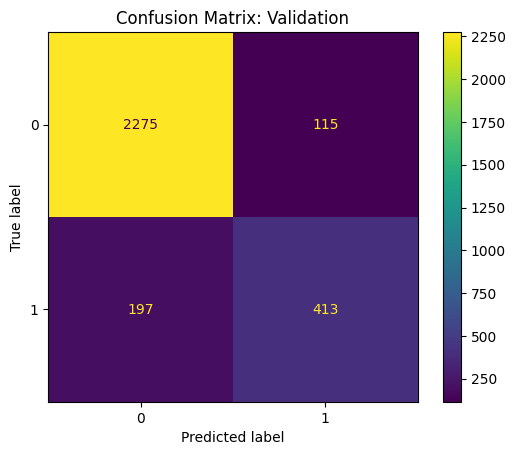

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


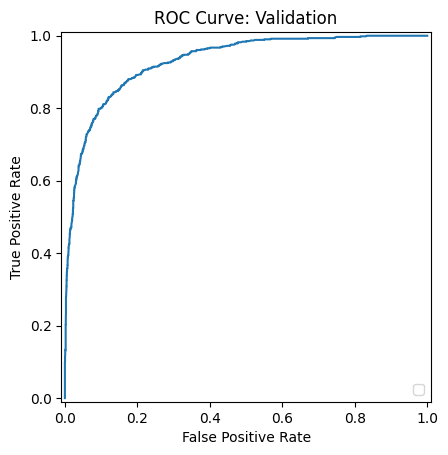

📊 Validation — AUROC: 0.930, F1 Score (threshold=0.5): 0.726


In [32]:
evaluate_model(pipeline_poly_4, val_df, 'Validation')

In [34]:
bank_customer_churn_prediction_pipe_poly_4 = {
    'pipeline': pipeline_poly_4,
    'preprocessor': preprocessor_poly_4,
    'categorical_transformer': categorical_transformer,
    'numeric_transformer': numeric_transformer,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

joblib.dump(bank_customer_churn_prediction_pipe, '/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction_pipe_poly_4.joblib')

['/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction_pipe_poly_4.joblib']

In [36]:
# Витягування об'єктів з пайплайну
preprocessor = pipeline_poly_4.named_steps['preprocessor']
poly        = preprocessor_poly_4.named_transformers_['num'].named_steps['poly']
scaler      = preprocessor_poly_4.named_transformers_['num'].named_steps['scaler']
encoder     = preprocessor_poly_4.named_transformers_['cat']
model       = pipeline_poly_4.named_steps['classifier']

In [40]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, poly, encoder, model, input_df: pd.DataFrame):
    input_df = input_df.copy()

    # 1. Додаємо ProductGroup
    input_df['ProductGroup'] = input_df['NumOfProducts'].apply(lambda x: '3+' if x >= 3 else str(int(x)))

    # 2. Фіксовані числові фічі (бо scaler.feature_names_in_ не працює)
    num_cols = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance']
    cat_cols = encoder.feature_names_in_

    # 3. Числові → поліноми → масштабування
    X_num = input_df[num_cols]
    X_num_poly = poly.transform(X_num)
    X_num_scaled = scaler.transform(X_num_poly)
    poly_feature_names = poly.get_feature_names_out(num_cols)
    X_num_df = pd.DataFrame(X_num_scaled, columns=poly_feature_names, index=input_df.index)

    # 4. Категоріальні → OneHotEncoder
    X_cat = input_df[cat_cols]
    X_cat_encoded = encoder.transform(X_cat)
    X_cat_df = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(), index=input_df.index)

    # 5. Об'єднання
    X_input = pd.concat([X_num_df, X_cat_df], axis=1)

    # 6. Прогноз
    prob = model.predict_proba(X_input)[:, 1]
    return prob


In [41]:
test_raw_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/test.csv')
test_raw_df['Exited'] = predict_raw_df(scaler, poly, encoder, model, test_raw_df)
submission_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/sample_submission.csv')
submission_df['Exited'] = test_raw_df['Exited']
submission_df.head()
submission_df.to_csv('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/submission_log_reg.csv', index=False)

In [43]:
# Маємо тут несбалансовані дані

base_df['Exited'].value_counts()

,count
Exited,
0.0,11948
1.0,3052


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?